# Exploring the New Sample Dataset

**Goal**: Test the weighting and hard cut config of the data loading process

In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import logging

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns

logging.basicConfig(level=logging.INFO)

/global/homes/d/danieltm/.conda/envs/gnn4itk/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data load

In [4]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0"
input_files = os.listdir(input_dir)
input_files = sorted([os.path.join(input_dir, f) for f in input_files])

In [6]:
cluster_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/clusters_evt1.txt"
particles_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/particles_evt1.txt"
spacepoints_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/spacepoints_evt1.txt"
tracks_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/tracks_evt1.txt"
detailed_tracks_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/detailedtracktruth_evt1.txt"
subevents_file = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0/subevents_evt1.txt"

In [ ]:
cluster_df = 

## Study CSV Processed

In [13]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
particles_file = os.path.join(input_dir, example_event_id + "-particles.csv")
truth_file = os.path.join(input_dir, example_event_id + "-truth.csv")

In [14]:
particles = pd.read_csv(particles_file)
truth = pd.read_csv(truth_file)

In [17]:
particles.columns

Index(['particle_id', 'subevent', 'barcode', 'px', 'py', 'pz', 'pt', 'eta',
       'vx', 'vy', 'vz', 'radius', 'status', 'charge', 'pdgId', 'pass',
       'vProdNIn', 'vProdNOut', 'vProdStatus', 'vProdBarcode', 'num_clusters'],
      dtype='object')

In [16]:
truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,particle_id_1,particle_id_2,hardware,...,localDir2_2,lengthDir0_2,lengthDir1_2,lengthDir2_2,glob_eta_2,glob_phi_2,eta_angle_2,phi_angle_2,region,module_id
0,0,-33.575,6.425,-265.00,0,-1,67340001952,67340001952,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
1,1,-33.825,3.150,-265.00,1,-1,67100000681,67100000681,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
2,2,-33.875,7.825,-265.00,2,-1,66530001223,66530001223,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
3,3,-34.000,2.550,-265.00,3,-1,66530001434,66530001434,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
4,4,-34.000,-7.400,-265.00,4,-1,66640000092,66640000092,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388451,387845,919.886,-111.201,2854.25,535335,535350,0,0,0,STRIP,...,0.32,59.8697,-6.03907,0.0,0.006380,1.41821,1.11585,0.006380,6.0,963713145652641792
388452,387846,957.169,-127.076,2854.25,535336,535349,0,0,0,STRIP,...,0.32,59.7865,-6.81369,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792
388453,387847,951.316,-165.305,2854.25,535338,535346,0,0,0,STRIP,...,0.32,59.4667,-9.19646,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792
388454,387848,919.594,-175.453,2854.25,535339,535345,0,0,0,STRIP,...,0.32,59.3168,-10.11820,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792


## Study Pyg

In [2]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
graph_file = os.path.join(input_dir, example_event_id + "-graph.pyg")
graph = torch.load(graph_file)

In [3]:
graph

Data(hit_id=[354890], x=[354890], y=[354890], z=[354890], r=[354890], phi=[354890], eta=[354890], region=[354890], cluster_x_1=[354890], cluster_y_1=[354890], cluster_z_1=[354890], cluster_x_2=[354890], cluster_y_2=[354890], cluster_z_2=[354890], norm_x=[354890], norm_y=[354890], norm_z_1=[354890], norm_z_2=[354890], count_1=[354890], charge_count_1=[354890], loc_eta_1=[354890], loc_phi_1=[354890], localDir0_1=[354890], localDir1_1=[354890], localDir2_1=[354890], lengthDir0_1=[354890], lengthDir1_1=[354890], lengthDir2_1=[354890], glob_eta_1=[354890], glob_phi_1=[354890], eta_angle_1=[354890], phi_angle_1=[354890], count_2=[354890], charge_count_2=[354890], loc_eta_2=[354890], loc_phi_2=[354890], localDir0_2=[354890], localDir1_2=[354890], localDir2_2=[354890], lengthDir0_2=[354890], lengthDir1_2=[354890], lengthDir2_2=[354890], glob_eta_2=[354890], glob_phi_2=[354890], eta_angle_2=[354890], phi_angle_2=[354890], track_edges=[2, 111217], particle_id=[111217], pt=[111217], radius=[11121

In [4]:
input_dir = "/global/cfs/cdirs/m3443/data/GNN4ITK/CommonFrameworkExamples/Example_1_Dev_A/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
graph_file = os.path.join(input_dir, example_event_id + "-graph.pyg")
graph = torch.load(graph_file)

In [5]:
graph

Data(hit_id=[328226], x=[328226], y=[328226], z=[328226], r=[328226], phi=[328226], eta=[328226], region=[328226], module_id=[328226], cluster_x_1=[328226], cluster_y_1=[328226], cluster_z_1=[328226], cluster_x_2=[328226], cluster_y_2=[328226], cluster_z_2=[328226], norm_x=[328226], norm_y=[328226], norm_z_1=[328226], eta_angle_1=[328226], phi_angle_1=[328226], eta_angle_2=[328226], phi_angle_2=[328226], norm_z_2=[328226], track_edges=[2, 131323], particle_id=[131323], pt=[131323], radius=[131323], primary=[131323], nhits=[131323], pdgId=[131323], config=[1], event_id='000000148')

In [70]:
new_graphs = []
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
unique_event_ids = list(set([f.split("-")[0] for f in os.listdir(input_dir)]))[:80]

# Loop over all events in the input directory
for event_id in tqdm(unique_event_ids):
    # Load the graph
    try:
        graph_file = os.path.join(input_dir, event_id + "-graph.pyg")
        graph = torch.load(graph_file)
        # Add the graph to the list of graphs
        new_graphs.append(graph)
    except:
        pass

100%|██████████| 80/80 [00:38<00:00,  2.06it/s]


In [16]:
old_graphs = []
input_dir = "/global/cfs/cdirs/m3443/data/GNN4ITK/CommonFrameworkExamples/Example_1_Dev/feature_store/trainset"
unique_event_ids = set([f.split("-")[0] for f in os.listdir(input_dir)])

# Loop over all events in the input directory
for event_id in tqdm(unique_event_ids):
    # Load the graph
    try:
        graph_file = os.path.join(input_dir, event_id + "-graph.pyg")
        graph = torch.load(graph_file)
        # Add the graph to the list of graphs
        old_graphs.append(graph)
    except:
        pass

100%|██████████| 80/80 [00:16<00:00,  4.98it/s]


<AxesSubplot: ylabel='Count'>

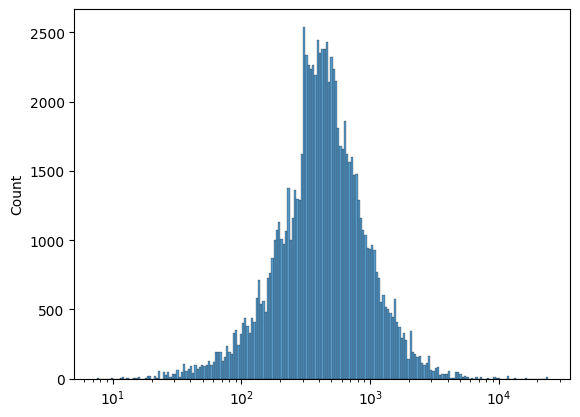

In [8]:
sns.histplot(graph.pt, log_scale=True)

In [71]:
old_samples_mean_truth = [g.track_edges.shape[1] for g in old_graphs]
new_samples_mean_truth = [g.track_edges.shape[1] for g in new_graphs]

In [72]:
old_samples_track_lengths = [g.nhits for g in old_graphs]
new_samples_track_lengths = [g.nhits for g in new_graphs]

In [73]:
old_samples_event_size = [g.x.shape[0] for g in old_graphs]
new_samples_event_size = [g.x.shape[0] for g in new_graphs]

In [74]:
old_samples_num_particles = [g.particle_id.unique().shape[0] for g in old_graphs]
new_samples_num_particles = [g.particle_id.unique().shape[0] for g in new_graphs]

In [75]:
old_samples_true_hits = [g.track_edges.unique().shape[0] for g in old_graphs]
new_samples_true_hits = [g.track_edges.unique().shape[0] for g in new_graphs]

In [76]:
old_samples_noise_hits = [g.x.shape[0] - g.track_edges.unique().shape[0] for g in old_graphs]
new_samples_noise_hits = [g.x.shape[0] - g.track_edges.unique().shape[0] for g in new_graphs]

In [77]:
old_samples_pt = [g.pt for g in old_graphs]
new_samples_pt = [g.pt for g in new_graphs]

In [78]:
old_samples_eta = [g.eta for g in old_graphs]
new_samples_eta = [g.eta for g in new_graphs]

Text(0.5, 1.0, 'Number of true edges per event')

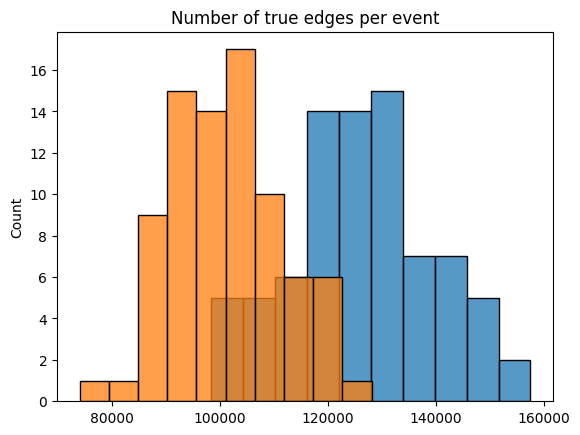

In [79]:
sns.histplot(old_samples_mean_truth, bins=10)
sns.histplot(new_samples_mean_truth, bins=10)
plt.title("Number of true edges per event")

Text(0.5, 1.0, 'Number of hits per track')

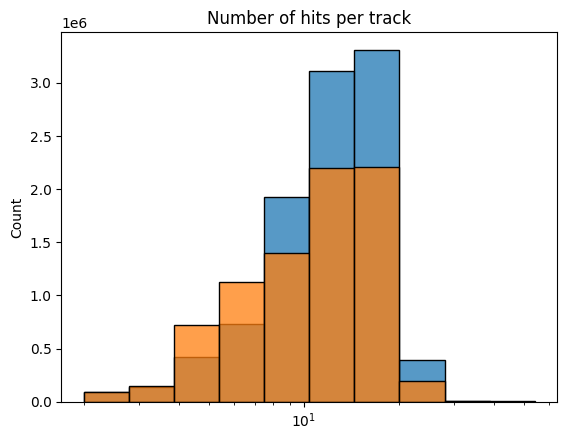

In [80]:
sns.histplot(torch.cat(old_samples_track_lengths), bins=10, log_scale=True)
sns.histplot(torch.cat(new_samples_track_lengths), bins=10, log_scale=True)
plt.title("Number of hits per track")

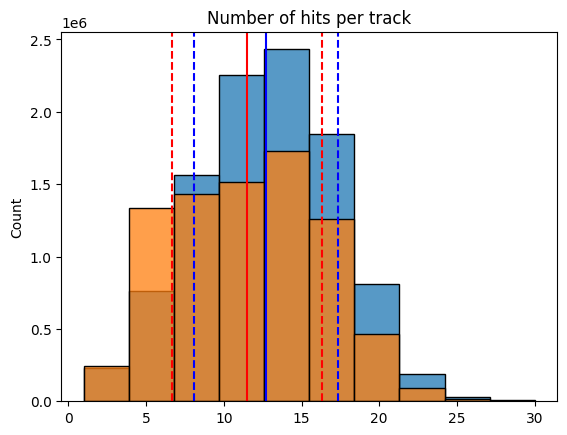

In [81]:
sns.histplot(torch.cat(old_samples_track_lengths), bins=10, binrange=[1, 30])
sns.histplot(torch.cat(new_samples_track_lengths), bins=10, binrange=[1, 30])
plt.title("Number of hits per track")
# add the mean and std
plt.axvline(torch.cat(old_samples_track_lengths).float().mean(), color="blue")
plt.axvline(torch.cat(new_samples_track_lengths).float().mean(), color="red")
plt.axvline(torch.cat(old_samples_track_lengths).float().mean() + torch.cat(old_samples_track_lengths).float().std(), color="blue", linestyle="--")
plt.axvline(torch.cat(new_samples_track_lengths).float().mean() + torch.cat(new_samples_track_lengths).float().std(), color="red", linestyle="--")
plt.axvline(torch.cat(old_samples_track_lengths).float().mean() - torch.cat(old_samples_track_lengths).float().std(), color="blue", linestyle="--")
plt.axvline(torch.cat(new_samples_track_lengths).float().mean() - torch.cat(new_samples_track_lengths).float().std(), color="red", linestyle="--")

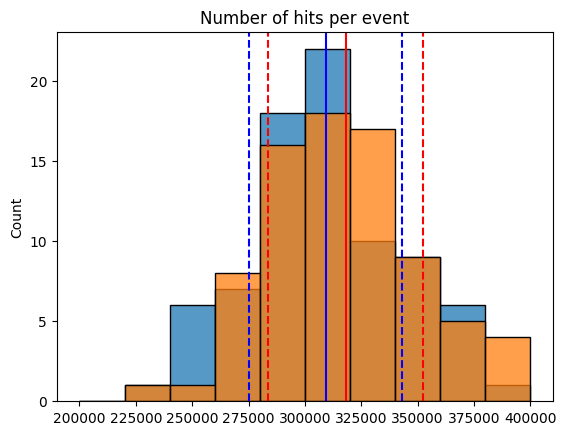

In [82]:
sns.histplot(old_samples_event_size, bins=10, binrange=[200000, 400000])
sns.histplot(new_samples_event_size, bins=10, binrange=[200000, 400000])
plt.title("Number of hits per event")
# add the mean and std
plt.axvline(np.mean(old_samples_event_size), color="blue")
plt.axvline(np.mean(new_samples_event_size), color="red")
plt.axvline(np.mean(old_samples_event_size) + np.std(old_samples_event_size), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_event_size) + np.std(new_samples_event_size), color="red", linestyle="--")
plt.axvline(np.mean(old_samples_event_size) - np.std(old_samples_event_size), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_event_size) - np.std(new_samples_event_size), color="red", linestyle="--")

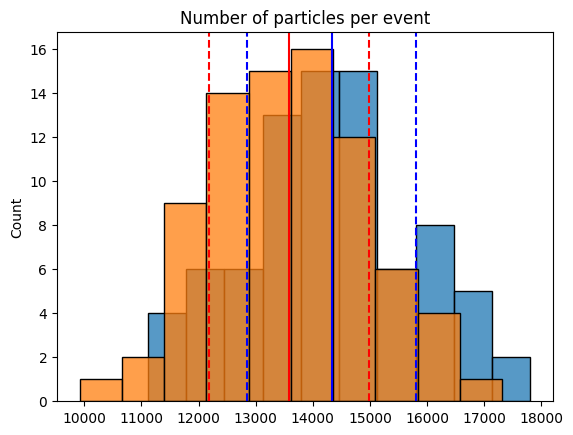

In [83]:
sns.histplot(old_samples_num_particles, bins=10)
sns.histplot(new_samples_num_particles, bins=10)
plt.title("Number of particles per event")
# add the mean and std
plt.axvline(np.mean(old_samples_num_particles), color="blue")
plt.axvline(np.mean(new_samples_num_particles), color="red")
plt.axvline(np.mean(old_samples_num_particles) + np.std(old_samples_num_particles), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_num_particles) + np.std(new_samples_num_particles), color="red", linestyle="--")
plt.axvline(np.mean(old_samples_num_particles) - np.std(old_samples_num_particles), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_num_particles) - np.std(new_samples_num_particles), color="red", linestyle="--")

Text(0.5, 0.8, 'new mean: 114034.77 +- 11667.52')

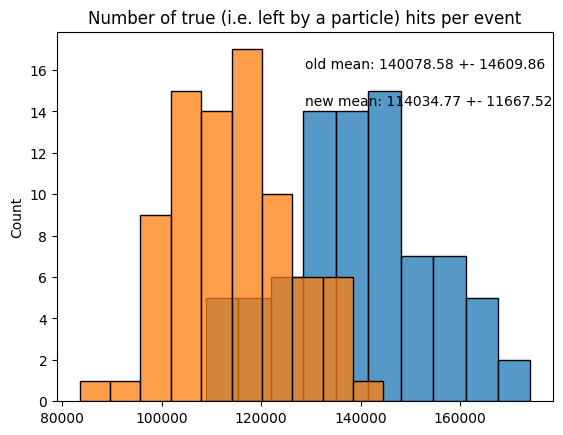

In [84]:
sns.histplot(old_samples_true_hits, bins=10)
sns.histplot(new_samples_true_hits, bins=10)
plt.title("Number of true (i.e. left by a particle) hits per event")
# add the mean and std in text
plt.text(0.5, 0.9, f"old mean: {np.mean(old_samples_true_hits):.2f} +- {np.std(old_samples_true_hits):.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"new mean: {np.mean(new_samples_true_hits):.2f} +- {np.std(new_samples_true_hits):.2f}", transform=plt.gca().transAxes)

Text(0.5, 0.8, 'new mean: 203983.30 +- 22988.57')

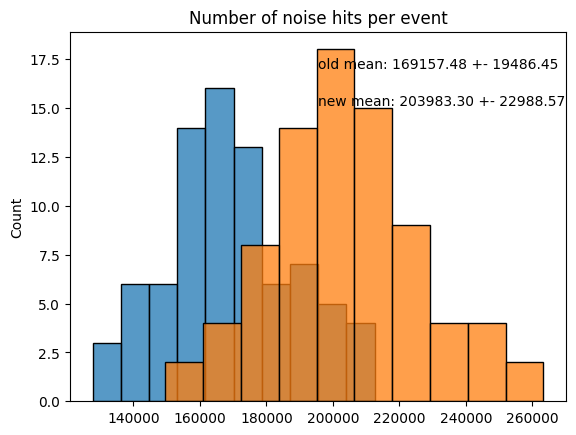

In [85]:
sns.histplot(old_samples_noise_hits, bins=10)
sns.histplot(new_samples_noise_hits, bins=10)
plt.title("Number of noise hits per event")
# add the mean and std in text
plt.text(0.5, 0.9, f"old mean: {np.mean(old_samples_noise_hits):.2f} +- {np.std(old_samples_noise_hits):.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"new mean: {np.mean(new_samples_noise_hits):.2f} +- {np.std(new_samples_noise_hits):.2f}", transform=plt.gca().transAxes)

Text(0.5, 0.8, 'new mean: 573.46 +- 947.09')

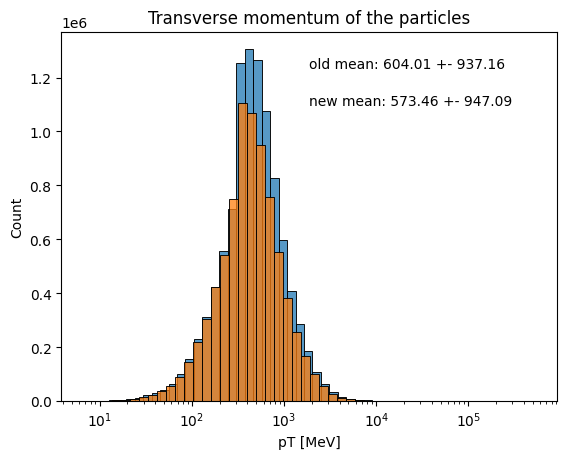

In [86]:
sns.histplot(torch.cat(old_samples_pt), bins=50, log_scale=True)
sns.histplot(torch.cat(new_samples_pt), bins=50, log_scale=True)
plt.title("Transverse momentum of the particles")
plt.xlabel("pT [MeV]")
# add the mean and std in text
plt.text(0.5, 0.9, f"old mean: {torch.cat(old_samples_pt).float().mean():.2f} +- {torch.cat(old_samples_pt).float().std():.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"new mean: {torch.cat(new_samples_pt).float().mean():.2f} +- {torch.cat(new_samples_pt).float().std():.2f}", transform=plt.gca().transAxes)

Text(0.5, 1.0, 'Pseudorapidity of the hits')

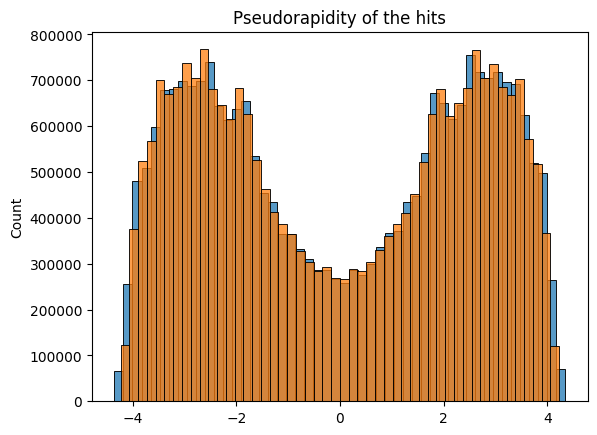

In [87]:
sns.histplot(torch.cat(old_samples_eta), bins=50)
sns.histplot(torch.cat(new_samples_eta), bins=50)
plt.title("Pseudorapidity of the hits")

In [69]:
sample

Data(hit_id=[296044], x=[296044], y=[296044], z=[296044], r=[296044], phi=[296044], eta=[296044], region=[296044], module_id=[296044], cluster_x_1=[296044], cluster_y_1=[296044], cluster_z_1=[296044], cluster_x_2=[296044], cluster_y_2=[296044], cluster_z_2=[296044], norm_x=[296044], norm_y=[296044], norm_z_1=[296044], eta_angle_1=[296044], phi_angle_1=[296044], eta_angle_2=[296044], phi_angle_2=[296044], norm_z_2=[296044], track_edges=[2, 120539], particle_id=[120539], pt=[120539], radius=[120539], primary=[120539], nhits=[120539], pdgId=[120539], config=[1], event_id='000000165')